# First, some setup

In [1]:
from pathlib import Path
import functools
import jax
import jax.numpy as jnp
import numpy as np
import jaxline
import note_seq
from typing import Generator, Mapping, Sequence, Text
import tensorflow as tf
import tensorflow_datasets as tfds
import time
import haiku as hk
import IPython
from PIL import Image
import datetime

import experiment
import perceiver_ar
import dataset
import sample_utils
import matplotlib.pyplot as plt

2022-05-25 23:19:40.894068: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [2]:
SAMPLE_RATE = 16000

# Restore a full experiment from a checkpoint

In [13]:
# modality = 'raw'
# sweep_name = 'random_mirrored_32'
# checkpoint_base = Path('/tmp/perceiver_ar')

# modality = 'raw'
# sweep_name = 'random_mirrored_131072'
# checkpoint_base = Path('/tmp/perceiver_ar_pretrained_checkpoints/random_mirrored_131072')

modality = 'image_w_positions'
sweep_name = 'imagenet_w_positions'
checkpoint_base = Path('/tmp/perceiver_ar_pretrained_checkpoints/imagenet_w_positions')

In [4]:
checkpoint_dir = sorted((checkpoint_base / 'models/latest').iterdir(), key=lambda x: x.stat().st_mtime)[-1]

print(f'Model will be loaded from: {checkpoint_dir}')

Model will be loaded from: /tmp/perceiver_ar_pretrained_checkpoints/imagenet_w_positions/models/latest/step_750000


In [5]:
config = experiment.get_config(sweep_name)
experiment.restore_state_to_in_memory_checkpointer(checkpoint_dir, config)

In [6]:
checkpointer = jaxline.platform.create_checkpointer(config, 'eval')
state = checkpointer.get_experiment_state('latest')

# Add the fields you want to restore here.
# Must include experiment_module.
state.global_step = 0
state.experiment_module = experiment.Experiment(
    'eval', jax.random.PRNGKey(config.random_seed),
    **config.experiment_kwargs)

checkpointer.restore('latest')
exp_params = jaxline.utils.get_first(state.experiment_module._params)
exp_state = jaxline.utils.get_first(state.experiment_module._state)

max_context_length = config.experiment_kwargs.config.data.max_context_length
# We want to store max_context_length plus the final prediction.
max_events_length = max_context_length + 1

events = np.zeros([1, max_events_length], np.int32)
events[:, 0] = dataset.SOS_ID

print('Restored step', state.global_step)

Restored step 750000


# Now run the model

In [7]:
#@title Set up the input sequence (NB: start_step ignored for some init types)

batch_size =   1#@param {type:"integer"}
input_sequence_init = 'zeros'  #@param ['zeros', 'mirror_input'] {type:"string"}
start_step = 1#@param {type:"integer"}

device_count = jax.local_device_count()
print('device count', device_count)

max_context_length = config.experiment_kwargs.config.data.max_context_length
# We want to store max_context_length plus the final prediction.
max_events_length = max_context_length + 1

if input_sequence_init == 'zeros':
  def gen_initial_events():
    events = np.zeros([device_count, batch_size, max_events_length], np.int32)
    # Add expected SOS prompt.
    events[:, :, 0] = dataset.SOS_ID
    return events
elif input_sequence_init == 'mirror_input':
  # Account for the SOS
  seq_len = config.experiment_kwargs.config.data.max_context_length - 2
  seq_len = seq_len // 2

  start_step = seq_len + 1
  print('Using input_sequence_init `mirror_input`. Setting '
        f'start_step to {start_step}.')

  def gen_initial_events():
    # Initialize with a random MirroredDataset sequence.
    events = np.zeros([device_count, batch_size, max_events_length], np.int32)
    rng = jax.random.PRNGKey(0)
    forward_sequence = jax.random.randint(
        rng, [device_count, batch_size, seq_len], 
        minval=dataset.NUM_RESERVED_TOKENS, 
        maxval=256 + dataset.NUM_RESERVED_TOKENS, 
        dtype=jnp.int32)
  
    # Force start_step to half the sequence length:
    events[:, :, 1:seq_len+1] = forward_sequence
    # Add expected SOS prompt.
    events[:, :, 0] = dataset.SOS_ID
    return events

if start_step < 1:
  raise ValueError('start_step must be >= 1 to account for the SOS token.')

# Make sure start_step doesn't exceed the maximum context of the model.
if start_step > max_context_length:
  print(f'Warning: start_step {start_step} exceeds '
        f'max_context_length used at training {max_context_length}.')

device count 1


In [8]:
#@title Memory parameters (set to 0 to use model defaults)
use_memory = True #@param {type:"boolean"}
max_context_length_memory = 0 #@param {type:"integer"}
z_index_dim_memory =  0#@param {type: "integer"}

model_kwargs = config.experiment_kwargs.config.model.perceiver_ar_kwargs
# These values can be adjusted, but set to defaults if not specified
if use_memory:
  if max_context_length_memory == 0:
    print('Using default max_context_length for memory: '
          f'{config.max_context_length}')
    max_context_length_memory = config.max_context_length
  if z_index_dim_memory == 0:
    print(f'Using default z_index_dim for memory: {model_kwargs.z_index_dim}')
    z_index_dim_memory = model_kwargs.z_index_dim


Using default max_context_length for memory: 12416
Using default z_index_dim for memory: 1024


In [20]:
#@title Set up sampling

@functools.partial(jax.jit, static_argnums=(2, 3, 4, 5))
def sample_sequences(
    events, rng, 
    start_step=1, 
    num_steps=-1,
    temperature=1.0, 
    top_p=1.0):
  if num_steps < 0:
    num_steps = events.shape[1] - start_step + 1

  # Start at position 1 because SOS must be at position 0.
  upper = min(num_steps + start_step, events.shape[1])
  print('start_step', start_step)
  print('upper', upper)

  if modality == 'image_w_positions':
    x_event_idxs = jnp.reshape(
        jnp.broadcast_to(jnp.arange(64)[None, :, None] + 1, [64, 64, 3]), [-1])
    y_event_idxs = jnp.reshape(
        jnp.broadcast_to(jnp.arange(64)[:, None, None] + 1, [64, 64, 3]), [-1])
    channel_event_idxs = jnp.reshape(
        jnp.broadcast_to(jnp.array([1, 2, 3]), [64, 64, 3]), [-1])

    event_idxs = jnp.stack(
        [x_event_idxs, y_event_idxs, channel_event_idxs], axis=1)

    # Account for SOS.
    event_idxs = jnp.concatenate(
        [jnp.ones([1, 3], dtype=jnp.int32), event_idxs + 1], axis=0)

    # Pad remaining positions.
    event_idxs = jnp.pad(
        event_idxs, [[0, events.shape[1] - event_idxs.shape[0]], [0, 0]])

    event_idxs = jnp.broadcast_to(event_idxs, events.shape + (3,))
  else:
    # Otherwise, assume linear event indices.
    event_idxs = jnp.arange(start=1, stop=events.shape[1] + 1)
    event_idxs = jnp.expand_dims(event_idxs, axis=-1)
    event_idxs = jnp.broadcast_to(event_idxs, events.shape + (1,))
  
  model_kwargs = config.experiment_kwargs.config.model.perceiver_ar_kwargs

  if use_memory:
    # Zero-initialize the memory.
    memory = sample_utils.initialize_memory(
        batch_size=batch_size,
        num_transformers_per_block=model_kwargs.num_transformers_per_block,
        num_cross_attend_heads=model_kwargs.num_cross_attend_heads,
        num_transformer_heads=model_kwargs.num_transformer_heads,
        num_z_channels=model_kwargs.num_z_channels,
        max_context_length_memory=max_context_length_memory,
        z_index_dim_memory=z_index_dim_memory,
        position_encoding_type=model_kwargs.position_encoding_type,
        memory_type='fixed_size_kv')

  # Build the parameters reused between model calls. 
  sample_position_args = dict(
      event_idxs=event_idxs,
      modality=modality,
      temperature=temperature,
      top_p=top_p,
      use_memory=use_memory,
  )

  # Package the (constant) params and state with the model.
  forward_fn = functools.partial(
      state.experiment_module.forward.apply,
      exp_params,
      exp_state,
  )

  if use_memory and start_step > 1:
    # Run forward the model with long context for one step to initialize 
    # the memory and get the first sample.
    events, rng, memory = sample_utils.sample_position(
        i=start_step,
        events_rng_memory=(events, rng, memory),
        forward_fn=forward_fn,
        condition_on='all_previous',
        **sample_position_args)
    start_step += 1

  if use_memory:
    condition_on_loop = 'most_recent_only'
  else:
    condition_on_loop = 'all'
  sample_positions_loop = functools.partial(
      sample_utils.sample_position,
      # i, events_rng_memory supplied by caller.
      forward_fn=forward_fn,
      condition_on=condition_on_loop,
      **sample_position_args)

  if use_memory:
    inputs = (events, rng, memory)
  else:
    inputs = (events, rng)
  
  outputs = jax.lax.fori_loop(
      start_step, upper, sample_positions_loop, inputs)
  
  return outputs

sample_sequences = jax.pmap(
    sample_sequences,
    static_broadcasted_argnums=(2, 3, 4, 5))

In [21]:
#@title Sample the sequence

#@markdown `num_steps`=-1 will fill the entire buffer.
num_steps =   -1#@param {type:"integer"}
temperature =   1.0#@param {type:"number"}
top_p =   1.0#@param {type:"number"}
random_seed = 0#@param{type:"integer"}

rng = jax.random.PRNGKey(random_seed)
rng = jax.random.split(rng, device_count)

events = gen_initial_events()

if 'outputs' in locals():
  del outputs
if 'memory' in locals():
  del memory
if 'seq' in locals():
  del seq

tick = time.time()
print('starting generation', tick)

outputs = sample_sequences(
    events, rng, start_step, num_steps, temperature, top_p)

outputs = jax.tree_map(lambda x: x.block_until_ready(), outputs)
tock = time.time()
print('generation complete', tock)
print(tock - tick, 'seconds')
print((tock - tick) / 60, 'minutes')

if use_memory:
  events, rng, memory = outputs
else:
  events, rng = outputs

# reshape to remove device axis
events = events.reshape((np.prod(events.shape[:2]),) + events.shape[2:])

starting generation 1653521802.615483
start_step 1
upper 193


2022-05-25 23:40:13.851999: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:61] 
********************************
Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
Compiling module pmap_sample_sequences.27
********************************


generation complete 1653522581.5779161
778.9624330997467 seconds
12.982707218329113 minutes


In [22]:
#@title Do the inputs and outputs of the mirrored_input test match?
if input_sequence_init == 'mirror_input':
  if num_steps < 0:
    num_steps = events.shape[1] - start_step + 1

  start_idx = max(start_step - num_steps, 0)
  end_idx = min(start_step+num_steps, max_context_length) 
  last_inputs = events[:, start_idx:start_step][:, ::-1]
  first_outputs = events[:, start_step:end_idx]
  print(f'Last inputs (reversed):\n {last_inputs}')
  print(f'First outputs:\n {first_outputs}')

No EOS token found.
Found SOS at index 0 as expected, removing.
Truncating 2 position(s) to ensure multiple of 3
Truncating 42 tuple(s) to ensure multiple of 64
-----
(64, 64, 3)


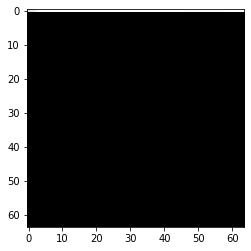

saving to /tmp/perceiver_ar_pretrained_checkpoints/imagenet_w_positions/inference/2022-05-25T234941.651172/im_0.png


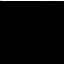

In [23]:
#@title Visualize or play the sampled sequence

inference_dir = checkpoint_base / 'inference' / datetime.datetime.now().isoformat().replace(":", "")
im_timestamp = time.time()

for i, seq in enumerate(events):
  eos_idx = jnp.argmax(seq == dataset.EOS_ID)
  if eos_idx:
    print(f'Found EOS at index {eos_idx}, truncating.')
    seq = seq[:eos_idx]
  else:
    print('No EOS token found.')

  if seq[0] == dataset.SOS_ID:
    print(f'Found SOS at index 0 as expected, removing.')
    seq = seq[1:]
  else:
    print(f'WARNING: SOS not found at index 0. This should not happen.')

  if modality in ['image', 'image_w_positions']:
    seq = seq - dataset.NUM_RESERVED_TOKENS
    rem = len(seq) % 3
    if rem > 0:
      print(f'Truncating {rem} position(s) to ensure multiple of 3')
      seq = seq[:-rem]
    seq = seq.reshape(-1, 3)
    if modality == 'image':
      seq -= jnp.broadcast_to([0, 256, 512], seq.shape)
    rem = len(seq) % 64
    if rem > 0:
      print(f'Truncating {rem} tuple(s) to ensure multiple of 64')
      seq = seq[:-rem]
    seq = seq.reshape(-1, 64, 3)

    seq = jnp.where(seq >= 0, seq, 0)
    print('-----')
    print(seq.shape)
    plt.imshow(seq)
    plt.show()

    inference_dir.mkdir(parents=True, exist_ok=True)
    im_filename = f'im_{i}.png'
    im_path = inference_dir / im_filename
    img = Image.fromarray(np.array(seq, dtype=np.uint8), mode='RGB')
    print('saving to', im_path)
    IPython.display.display(img)
    img.save(im_path)
  elif modality == 'raw':
    print('Shape:', seq.shape)
    print(seq)
    print('#####')
  else:
    raise ValueError(f'Unknown modality: {modality}')